Kaggle Link: https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

Abstract: Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.

Metric Used: F1 Macro and F1 Micro


why: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

Paper: https://arxiv.org/pdf/1802.07858.pdf

In [1]:
import warnings
warnings.filterwarnings("ignore")
# what is the probelem you are having?
# ok let me show

In [2]:
import pandas as pd
# import sqlite3
import csv
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import os

from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
%matplotlib inline

In [3]:
df = pd.read_csv(r'F:\mpst_full_data.csv', delimiter=',')

In [4]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 14828 rows and 6 columns


In [5]:
df.head(5)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14828 entries, 0 to 14827
Data columns (total 6 columns):
imdb_id            14828 non-null object
title              14828 non-null object
plot_synopsis      14828 non-null object
tags               14828 non-null object
split              14828 non-null object
synopsis_source    14828 non-null object
dtypes: object(6)
memory usage: 695.1+ KB


In [7]:
df["tag_count"] = df["tags"].apply(lambda text: len(text.split(" ")))

In [8]:
#Sorting data according to imdb_id in ascending order
sorted_data=df.sort_values('imdb_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
df=sorted_data.drop_duplicates(subset={"imdb_id","title","plot_synopsis"}, keep='first', inplace=False)
df.shape

(14828, 7)

In [10]:
df.head(4)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tag_count
8814,tt0000091,Le manoir du diable,The film opens with a large bat flying into a ...,"paranormal, gothic",train,wikipedia,2
7085,tt0000225,La belle et la bête,A widower merchant lives in a mansion with his...,fantasy,train,wikipedia,1
11909,tt0000230,Cendrillon,"A prologue in front of the curtain, suppressed...",fantasy,train,wikipedia,1
548,tt0000417,Le voyage dans la lune,"At a meeting of the Astronomic Club, its presi...","psychedelic, satire",train,imdb,2


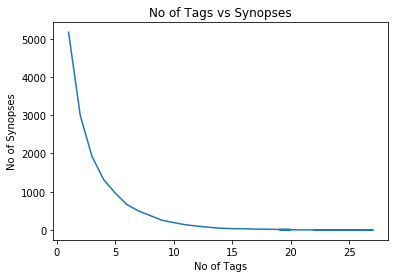

In [11]:
# distribution of number of tags per question
df.tag_count.value_counts().plot()
plt.title('No of Tags vs Synopses')
plt.xlabel('No of Tags')
plt.ylabel('No of Synopses')
plt.show()

## Analysis of Tags

### Unique Tags

In [12]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=False)
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(df['tags'])

In [13]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 14828
Number of unique tags : 147


In [14]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[0:10])

Some of the tags we have : ['absurd', 'absurd,', 'action', 'action,', 'adult', 'allegory', 'allegory,', 'alternate', 'anti', 'atmospheric']


### Number of times a tag appeared 

In [15]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [16]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,absurd,11
1,"absurd,",259
2,action,111
3,"action,",553
4,adult,128


In [17]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

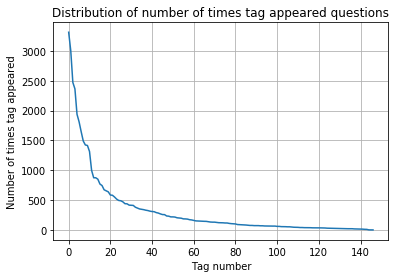

In [18]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

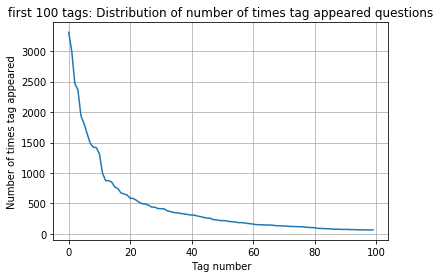

4 [3311  490  220  118]


In [19]:
plt.plot(tag_counts[0:100])
plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:100:25]), tag_counts[0:100:25])

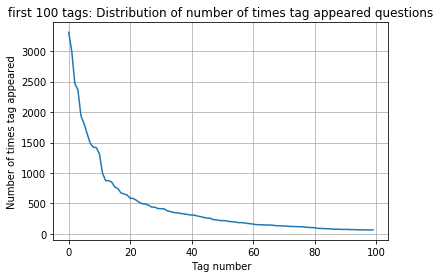

20 [3311 1811 1315  770  586  490  415  347  310  259  220  187  161  146
  132  118  102   84   74   68]


In [20]:
plt.plot(tag_counts[0:100])
plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

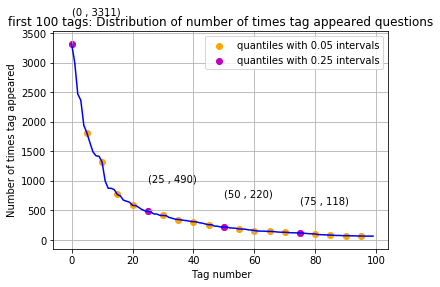

20 [3311 1811 1315  770  586  490  415  347  310  259  220  187  161  146
  132  118  102   84   74   68]


In [21]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

## Tags per movie

In [22]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 14828 datapoints.
[2, 1, 1, 2, 2]


In [23]:
print( "Maximum number of tags per movie: %d"%max(tag_quest_count))
print( "Minimum number of tags per movie: %d"%min(tag_quest_count))
print( "Avg. number of tags per movie: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per movie: 27
Minimum number of tags per movie: 1
Avg. number of tags per movie: 3.248854


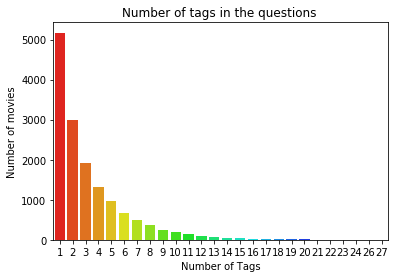

In [24]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of movies")
plt.show()

### Most frequent tags

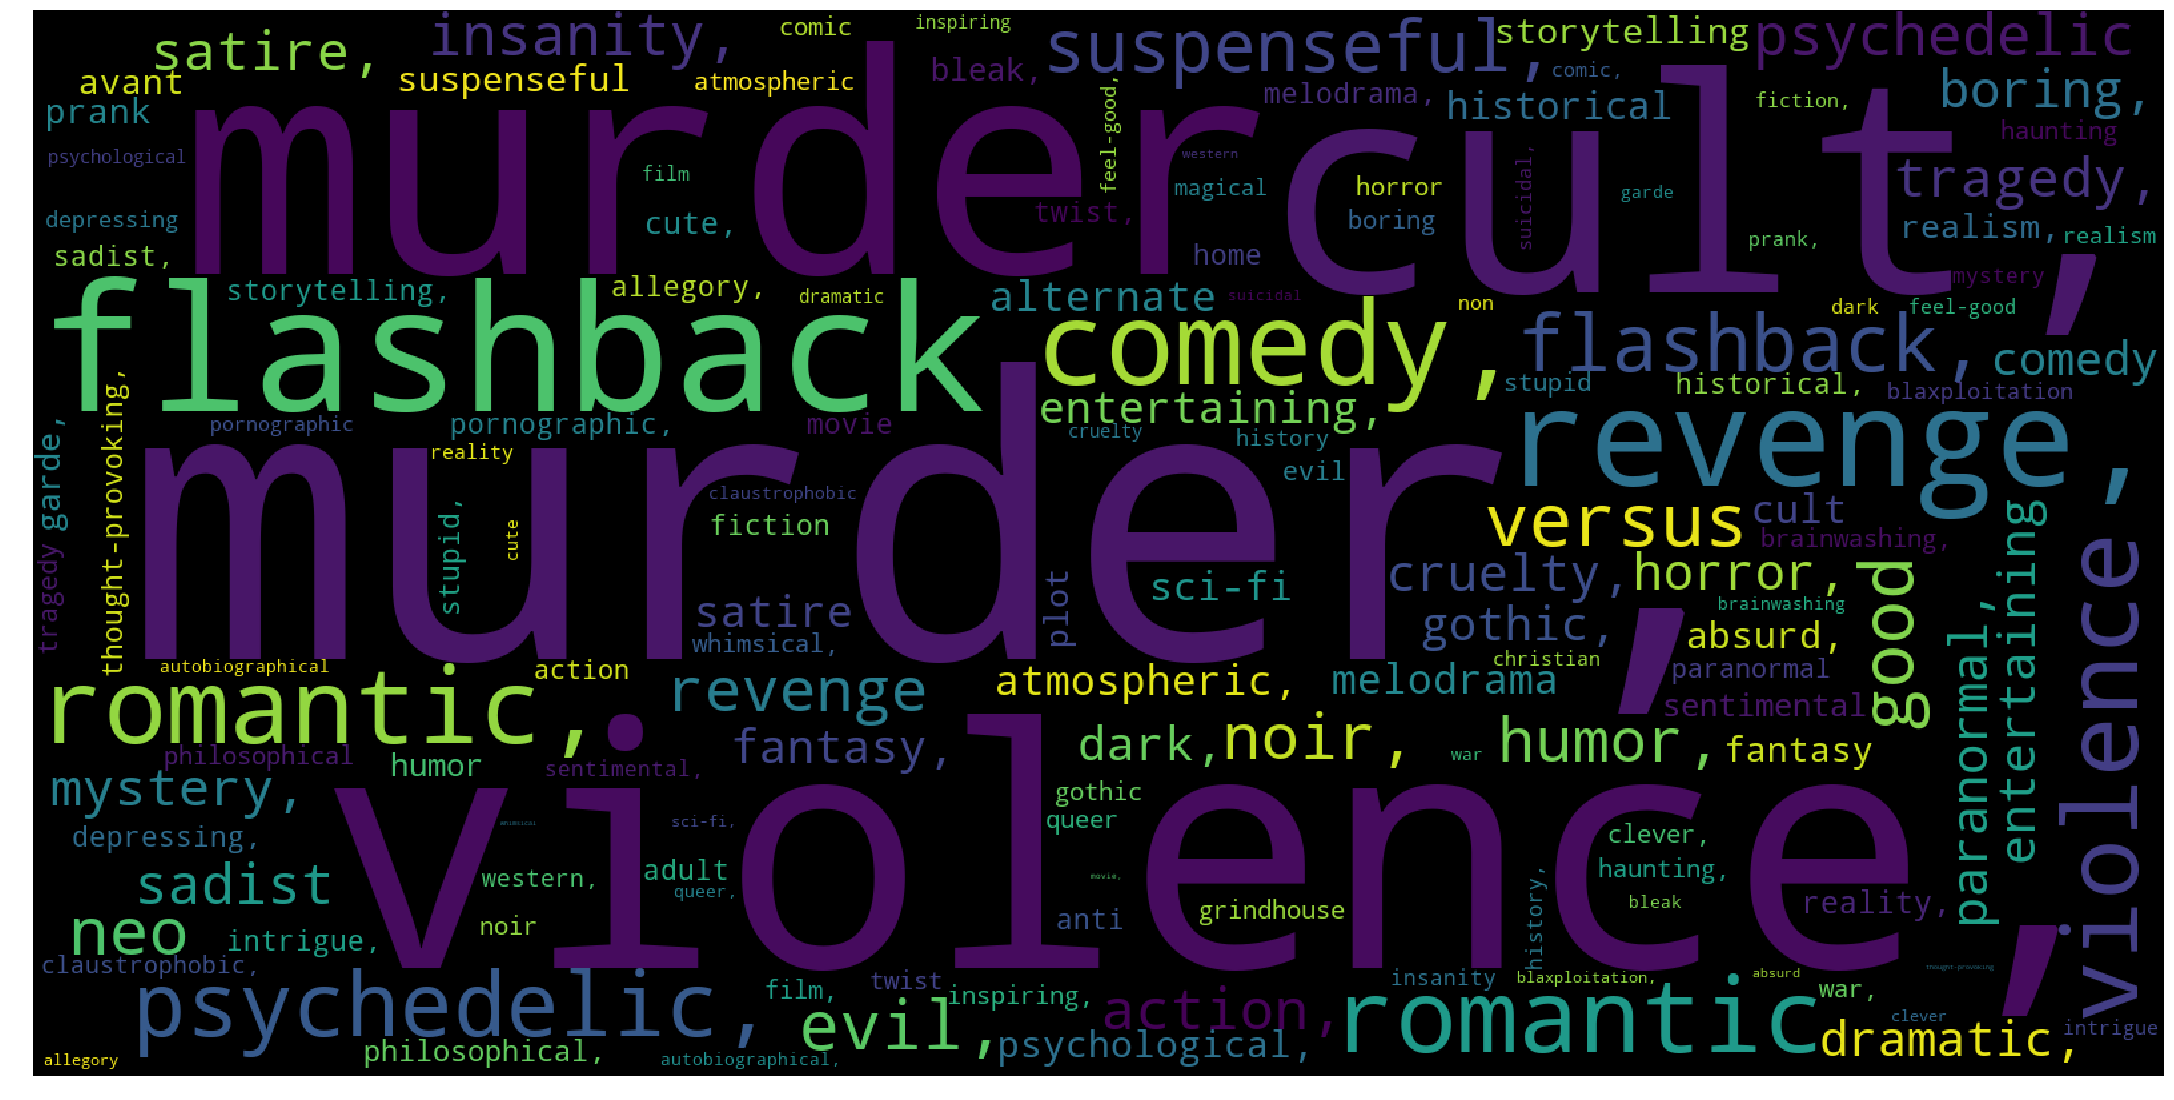

Time taken to run this cell : 0:00:03.753344


In [25]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)



### Top 20 Tags

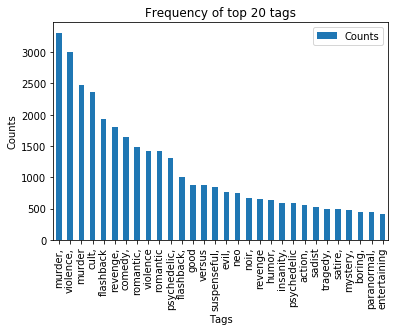

In [26]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()



## Cleaning and Pre-Processing

In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

In [28]:
from tqdm import tqdm


In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [30]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [31]:
df.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'tags', 'split', 'synopsis_source',
       'tag_count'],
      dtype='object')

In [32]:
preprocessed_synopsis = []
# tqdm is for printing the status bar
for sentance in tqdm(df['plot_synopsis'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_synopsis.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 14828/14828 [00:30<00:00, 501.23it/s]


In [33]:
len(df['tags'])

14828

In [34]:
# import numpy as np
# df=np.hstack((preprocessed_synopsis,df['tags'])) 


In [35]:
# I have done all the cleaning and all
# I am having problem modelling
# I tried doing it as per stackoverflow case study, but isn't working that way
# stackoverflow is opened in parallel tab for reference
# what you mean by not working?

In [36]:
 df1 = pd.DataFrame()

In [37]:
df1.head(3)

""


In [38]:
df['tags'][0]

'cult, horror, gothic, murder, atmospheric'

In [39]:
preprocessed_synopsis[10]

'two men friends john jim compete hand mary start journey westward mary betrothed john soon finds lush behaviors native americans ambush train attack leaves party low supply water fearing dehydration need john jim set water jim gives water older gentleman john gives jim last drop water thus sacrificing train continue westward jim finds water supply energy john gave last drop water train rescued troops publicity preproduction last drop water promoted extras well show detail money going western biograph company heavily promoting film one highest state production within film industry day trying prove modernity state change within film industry considered griffith way continuing career since western time losing popularity late break western genre title film changed wagon train going westward changed prior film release date california variety environments used within film starting become popular filmmakers access natural various landscapes themes whole film allusion life sir philip sydney m

### Converting tags for multilabel problems 

In [40]:
# preprocessed_data=df1
# this was just mistake ignore

In [41]:
# print("number of data points in sample :", preprocessed_synopsis.shape[0])
# print("number of dimensions :", preprocessed_synopsis.shape[1])

In [42]:
# preprocessed_data there is nothinging in this?
# I know. I was trying ways taking help from stakoverflow.com
# Some variable names are from there, which I forgot to delete
# you don't need to excatly do what we have done in the SO
# you think of logic whichcan work with this data
#  Actually I have preprocessed and cleaned data. Just help me with modelling
# where is your y values stored?
# can i just clean the mess. I was trying something, so have a little mess now. Y values are down below

##### Splitting into Train and Test

In [43]:
def remove_spaces(x):
    x=x.split(",")
    nospace=[]
    for item in x:
        item=item.lstrip()
        nospace.append(item)
    return (",").join(nospace)  

df['tags']=df['tags'].apply(remove_spaces)

train=df.loc[(df.split=='train')|(df.split=="val")]
train=train.reset_index()
test=df.loc[df.split=='test']
test=test.reset_index()

In [44]:
train.shape

(11862, 8)

In [45]:
print("number of datapoints for training: ",train.shape[0])
print("number of datapoints for test: ",test.shape[0])

number of datapoints for training:  11862
number of datapoints for test:  2966


### Converting tags to Multiple label Vectors

In [46]:
# binary='true' will give a binary vectorizer
# vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=None)
# vectorizer = CountVectorizer()
# ths is correct only
# but once you have it done, we need to check the contents of the multilabel_y
# multilabel_y = vectorizer.fit_transform(df['tags'])


vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
y_train = vectorizer.fit_transform(train['tags']).toarray()
y_test=vectorizer.transform(test['tags']).toarray()

In [47]:
vectorizer.get_feature_names()

['absurd',
 'action',
 'adult comedy',
 'allegory',
 'alternate history',
 'alternate reality',
 'anti war',
 'atmospheric',
 'autobiographical',
 'avant garde',
 'blaxploitation',
 'bleak',
 'boring',
 'brainwashing',
 'christian film',
 'claustrophobic',
 'clever',
 'comedy',
 'comic',
 'cruelty',
 'cult',
 'cute',
 'dark',
 'depressing',
 'dramatic',
 'entertaining',
 'fantasy',
 'feel-good',
 'flashback',
 'good versus evil',
 'gothic',
 'grindhouse film',
 'haunting',
 'historical',
 'historical fiction',
 'home movie',
 'horror',
 'humor',
 'insanity',
 'inspiring',
 'intrigue',
 'magical realism',
 'melodrama',
 'murder',
 'mystery',
 'neo noir',
 'non fiction',
 'paranormal',
 'philosophical',
 'plot twist',
 'pornographic',
 'prank',
 'psychedelic',
 'psychological',
 'queer',
 'realism',
 'revenge',
 'romantic',
 'sadist',
 'satire',
 'sci-fi',
 'sentimental',
 'storytelling',
 'stupid',
 'suicidal',
 'suspenseful',
 'thought-provoking',
 'tragedy',
 'violence',
 'western',
 

### Baseline Model

#### Top 5 tags
1. Murder
2. Violence
3. Cult
4. Flashback
5. Romantic


In [48]:
top_5_tags="murder,violence,romantic, cult, flashback"
test['baseline_prediction']=top_5_tags

In [49]:
multilabel_y_test_baseline = vectorizer.transform(test['baseline_prediction'])
print("micro f1 scoore :",metrics.f1_score(y_test,multilabel_y_test_baseline, average = 'micro'))

micro f1 scoore : 0.29609375


In [86]:
def plot(a):
    figure=plt.figure()
    plt.plot(np.log10(np.array([10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1])),a.mean_train_score,label="Train")
    plt.plot(np.log10(np.array([10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1])),a.mean_test_score,label="Test")
    plt.xlabel("Log10 of parameters")
    plt.ylabel("F1_micro")
    plt.title("F1_micro vs log10 of parameters")
    plt.xlim((-8,1))
    plt.legend()
    plt.show()
 

In [77]:
train.columns

Index(['index', 'imdb_id', 'title', 'plot_synopsis', 'tags', 'split',
       'synopsis_source', 'tag_count'],
      dtype='object')

## Starting with Machine Learning Models
### Logistic Regression

In [78]:
vectorizer = TfidfVectorizer(min_df=15,max_df=0.9)
# vectorizer.fit(train['preprocessed_plots'])
x_train=vectorizer.fit_transform(train['plot_synopsis'])
x_test=vectorizer.transform(test['plot_synopsis'])

In [79]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(x_train, y_train)

print ("Best cross-validation score:",model.best_score_)
print ("Best parameters:",model.best_params_)

Best cross-validation score: 0.2818527493062433
Best parameters: {'estimator__alpha': 1e-07}


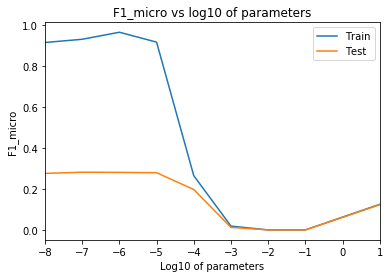

In [87]:
plot(pd.DataFrame(model.cv_results_))

In [96]:
predictions=model.predict(x_test)

In [97]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict (x_test)

# precision = precision_score(y_test, predictions, average='micro')
# recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Accuracy : 0.06776803776129467
Hamming loss  0.04024958924145005
Micro-average quality numbers
Precision: 0.3523, Recall: 0.2616, F1-measure: 0.1987


In [98]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=10**-6, penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict (x_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Accuracy : 0.04753877275792313
Hamming loss  0.05135669037827776
Micro-average quality numbers
Precision: 0.3628, Recall: 0.2627, F1-measure: 0.3047


#### Support Vector Machine(SVM)


In [99]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}


clf = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3,verbose=10)

model.fit(x_train, y_train)
# predictions=model.predict(x_test)
print ("The best cross-validation score:",model.best_score_)
print ("The best parameters:",model.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  23 out of  27 | elapsed:  1.8min remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.1min finished


The best cross-validation score: 0.27956382696177984
The best parameters: {'estimator__alpha': 1e-05}


In [100]:
predictions=model.predict(x_test)

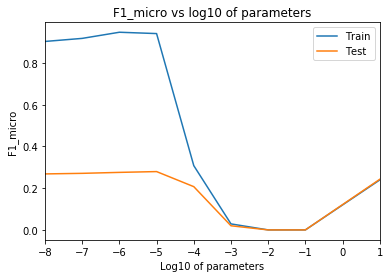

In [101]:
plot(pd.DataFrame(model.cv_results_))

In [102]:
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


# print (metrics.classification_report(y_test, predictions))

Micro-average quality numbers
Precision: 0.3703, Recall: 0.2571, F1-measure: 0.3035


In [103]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


Accuracy : 0.05293324342548887
Hamming loss  0.05056366520091554


In [105]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict (x_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6695, Recall: 0.1129, F1-measure: 0.1933


In [106]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


Accuracy : 0.06473364801078894
Hamming loss  0.04039204885414985


#### Using Bi-Grams in TFIDF Vectorizations

In [107]:
vectorizer = TfidfVectorizer(min_df=15,max_df=0.9, ngram_range=(2,2))
# vectorizer.fit(train['preprocessed_plots'])
x_train=vectorizer.fit_transform(train['plot_synopsis'])
x_test=vectorizer.transform(test['plot_synopsis'])

### Logistic Regression

In [115]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(x_train, y_train)

print ("Best cross-validation score:",model.best_score_)
print ("Best parameters:",model.best_params_)

Best cross-validation score: 0.27833144606535737
Best parameters: {'estimator__alpha': 1e-07}


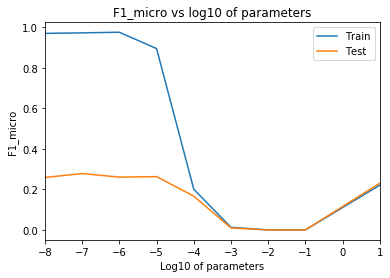

In [116]:
plot(pd.DataFrame(model.cv_results_))

In [117]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


Accuracy : 0.07012811867835468
Hamming loss  0.041645693445908086


In [118]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=10**-5, penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict (x_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Accuracy : 0.07181389076196898
Hamming loss  0.04138926614304845
Micro-average quality numbers
Precision: 0.5460, Recall: 0.2013, F1-measure: 0.2941


### SVM

In [119]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(x_train, y_train)

print ("Best cross-validation score:",model.best_score_)
print ("Best parameters:",model.best_params_)

Best cross-validation score: 0.27343688068274374
Best parameters: {'estimator__alpha': 1e-05}


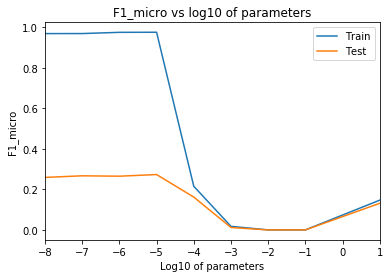

In [120]:
plot(pd.DataFrame(model.cv_results_))

In [121]:
# model = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',n_jobs=-1, alpha=0.00001),n_jobs=-1)



# model.fit(x_train, y_train)
# predictions=model.predict(y_test)

# precision = precision_score(y_test, predictions, average='micro')
# recall = recall_score(y_test, predictions, average='micro')
# f1 = f1_score(y_test, predictions, average='micro')
 
# print("Micro-average quality numbers")
# print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict (x_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Accuracy : 0.054956169925826026
Hamming loss  0.045040980881919976
Micro-average quality numbers
Precision: 0.4495, Recall: 0.2283, F1-measure: 0.3028


### Feature Engineering

Sources
1. https://www.analyticsvidhya.com/blog/2017/01/ultimate-guide-to-understand-implement-natural-language-processing-codes-in-python/

2. https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

Topic Modelling Using LDA

In [122]:
import pickle
import gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation

C:\Users\Cyborg\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cyborg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [123]:
vectorizer_topic =CountVectorizer(min_df=15,max_df=0.9)
vectorizer_topic.fit(train['plot_synopsis'])
x_lda_train=vectorizer_topic.transform(train['plot_synopsis'])
x_lda_test=vectorizer_topic.transform(test['plot_synopsis'])

In [124]:
x_lda_train.shape

(11862, 19232)

In [125]:
x_lda_test.shape

(2966, 19232)

In [126]:
lda_model = LatentDirichletAllocation(n_components=15, max_iter=5,learning_method='online',random_state=0,learning_offset=50)
lda_train = lda_model.fit_transform(x_lda_train)
lda_test = lda_model.transform(x_lda_test)

In [127]:
print(lda_train.shape, lda_test.shape)

(11862, 15) (2966, 15)


In [128]:
topic_assigned=np.argsort(lda_train)[:,0]

In [184]:
vv=pd.DataFrame({'Synopsis':train['plot_synopsis'],'Label_assigned':topic_assigned})

In [185]:
vv['Label_assigned'].value_counts()

7     7036
12    2497
10    1873
6      252
1      135
5       26
11      15
8       13
3        6
2        4
0        3
14       1
13       1
Name: Label_assigned, dtype: int64

### Top n Words of each Topic

In [130]:
#https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
display_topics(lda_model,vectorizer_topic.get_feature_names(),10)

Topic 0:
they into it them him from are out up then
Topic 1:
ghost leo jean chloe richie hannah clara eva hamlet ken
Topic 2:
are they their an ship from crew captain them island
Topic 3:
her tom she king him chris kate jerry they their
Topic 4:
him her an from has their was after at be
Topic 5:
earth alien dr from planet are ship it control space
Topic 6:
bill dave vampire sean marcus maria van sally linda vampires
Topic 7:
de el al la que le mickey su carlos se
Topic 8:
david her rose john him alan roy richard nina nancy
Topic 9:
she her it him they tells says at was out
Topic 10:
batman doug todd khan wayne cindy india maya raj singh
Topic 11:
charlie michael jim scott jason him army ryan at soldiers
Topic 12:
sword karan juan dalton lola rama ninja japanese samurai tanner
Topic 13:
him they at out up it from them has car
Topic 14:
her she him at they when has out up after


In [131]:
lda_train.shape

(11862, 15)

In [186]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(lda_train, y_train)
predictions=model.predict(lda_test)
print ("Best cross-validation score:",model.best_score_)
print ("Best parameters:",model.best_params_)

Best cross-validation score: 0.23700989275811063
Best parameters: {'estimator__alpha': 1e-07}


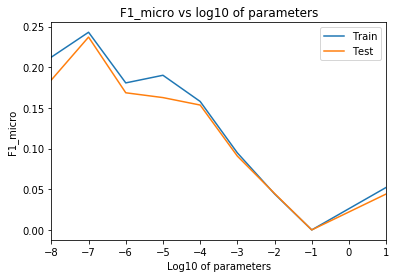

In [187]:
plot(pd.DataFrame(model.cv_results_))

In [188]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=10**-7, penalty='l1'), n_jobs=-1)
classifier.fit(lda_train, y_train)
predictions = classifier.predict(lda_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.3527, Recall: 0.1787, F1-measure: 0.2372


In [132]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(lda_train, y_train)
predictions=model.predict(lda_test)
print ("Best cross-validation score:",model.best_score_)
print ("Best parameters:",model.best_params_)

Best cross-validation score: 0.21497088757977853
Best parameters: {'estimator__alpha': 1e-08}


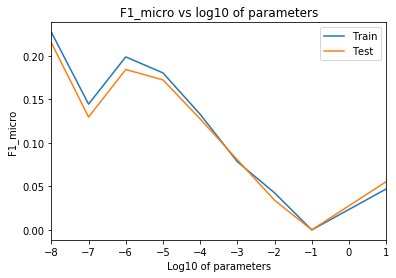

In [133]:
plot(pd.DataFrame(model.cv_results_))

In [134]:
lda_test.shape

(2966, 15)

In [135]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(lda_train, y_train)
predictions = classifier.predict(lda_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.3501, Recall: 0.1403, F1-measure: 0.2003


In [136]:
# print("Accuracy :",metrics.accuracy_score(y_test, predictions))
# print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


In [137]:
# for i in range(11862):
#     top_topics = lda_t.get_document_topics(m_train[i], minimum_probability=0.0)
#     topic_vec = [top_topics[i][1] for i in range(20)]
#     train_vecs.append(topic_vec)

In [138]:
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cyborg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Cyborg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [139]:
# Let's create a function to pull out nouns and verbs from a string of text
# Function taken after single google search
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'VB'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [140]:
data_nouns_adj_train = pd.DataFrame(train['plot_synopsis'].apply(nouns_adj))
data_nouns_adj_test = pd.DataFrame(test['plot_synopsis'].apply(nouns_adj))

In [141]:
data_nouns_adj_train.head()

,plot_synopsis
0,film opens bat flying castle bat circles room ...
1,widower merchant lives mansion children sons d...
2,prologue front curtain suppressed premiere int...
3,meeting Astronomic Club president Professor Ba...
4,Joe is New York newsboy lives grandmother sell...


In [142]:
vectorizer =CountVectorizer(min_df=5,max_df=0.8)
m_train=vectorizer.fit_transform(data_nouns_adj_train['plot_synopsis'])
# m_train=vectorizer.transform(data_nouns_adj.preprocessed_plots)

In [143]:
m_test=vectorizer.transform(data_nouns_adj_test['plot_synopsis'])

In [144]:
print(m_train.shape)
print(m_test.shape)

(11862, 31020)
(2966, 31020)


In [145]:
lda_model = LatentDirichletAllocation(n_components=20, max_iter=10,learning_method='online')
lda_model_train = lda_model.fit_transform(m_train)
lda_model_test = lda_model.transform(m_test)

In [146]:
lda_model_train.shape

(11862, 20)

In [147]:
params = {
    "estimator__alpha": [10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1, 10**2, 10**3]
}

clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(lda_model_train, y_train)
predictions=model.predict(lda_model_test)
print ("The best cross-validation score:",model.best_score_)
print ("The best parameters:",model.best_params_)

The best cross-validation score: 0.19630381005577013
The best parameters: {'estimator__alpha': 1e-06}


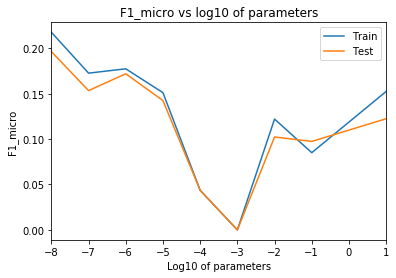

In [148]:
plot(pd.DataFrame(model.cv_results_))

In [149]:
# print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


Hamming loss  0.07181863941572564


In [150]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(lda_model_train, y_train)
predictions = classifier.predict(lda_model_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.3399, Recall: 0.1300, F1-measure: 0.1881


### Using TFIDF and Topic Modelling together

In [151]:
vectorizer = TfidfVectorizer(min_df=15,max_df=0.9)
vectorizer.fit(train['plot_synopsis'])
x_train=vectorizer.transform(train['plot_synopsis'])
x_test=vectorizer.transform(test['plot_synopsis'])

In [152]:
x_train.shape

(11862, 19232)

In [153]:
lda_model_train.shape

(11862, 20)

In [154]:
lda_train.shape

(11862, 15)

In [155]:
x_train=hstack((x_train,lda_train))

In [156]:
x_test=hstack((x_test,lda_test))

In [157]:
print(x_train.shape)
print(x_test.shape)

(11862, 19247)
(2966, 19247)


In [158]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(x_train, y_train)
predictions=model.predict(x_test)
print ("The best cross-validation score:",model.best_score_)
print ("The best parameters:",model.best_params_)

The best cross-validation score: 0.28214356806299407
The best parameters: {'estimator__alpha': 1e-06}


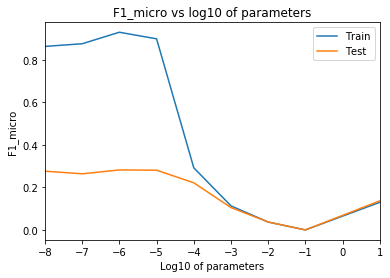

In [159]:
plot(pd.DataFrame(model.cv_results_))

In [160]:
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Hamming loss  0.05124272268811792


In [161]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.4486, Recall: 0.2312, F1-measure: 0.3051


In [162]:
lda_model.components_[0:10]

array([[5.00000638e-02, 1.31784935e+01, 9.59660313e+00, ...,
        5.00000032e-02, 5.00000027e-02, 5.00000030e-02],
       [5.00000650e-02, 5.00000048e-02, 5.00000147e-02, ...,
        5.00000043e-02, 5.00000454e-02, 5.00000593e-02],
       [5.00000050e-02, 5.00000115e-02, 1.43503497e+01, ...,
        5.00000117e-02, 5.00001733e-02, 5.00001679e-02],
       ...,
       [5.00000838e-02, 5.45882830e+01, 5.00015661e-02, ...,
        2.59719464e+01, 5.00000364e-02, 5.00000490e-02],
       [5.00001566e-02, 5.00000581e-02, 5.00000461e-02, ...,
        5.00000027e-02, 5.00000024e-02, 5.00000030e-02],
       [5.00002810e-02, 5.00000077e-02, 5.00000059e-02, ...,
        5.00000157e-02, 5.00005282e-02, 5.00009494e-02]])

In [163]:
lda_model.components_.shape

(20, 31020)

In [164]:
topic_train_assigned=lda_model_train.argmax(axis=1)
topic_test_assigned=lda_model_test.argmax(axis=1)

In [165]:
def extract_features(components,topic_assigned):
    topic_features=[]
    for i in topic_assigned:
        top_10=sorted(components[i],reverse=True)[:10]
        topic_features.append(top_10)
    return topic_features  

In [166]:
components=lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]

In [167]:
topic_train=extract_features(components,topic_train_assigned)
topic_test=extract_features(components,topic_test_assigned)

In [168]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(topic_train, y_train)
predictions=model.predict(topic_test)
print ("The best cross-validation score:",model.best_score_)
print ("The best parameters:",model.best_params_)

The best cross-validation score: 0.13994625409706204
The best parameters: {'estimator__alpha': 1e-07}


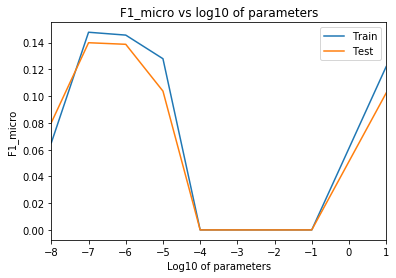

In [169]:
plot(pd.DataFrame(model.cv_results_))

In [170]:
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Hamming loss  0.05317067611332187


In [171]:
model = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
model.fit(topic_train, y_train)
predictions=model.predict(topic_test)
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.0292, Recall: 0.0288, F1-measure: 0.0290


### Concating TFIDF, Topics and Topic Scores together

In [172]:
x_train=hstack((x_train,topic_train))
x_test=hstack((x_test,topic_test))

In [173]:
print(x_train.shape)
print(x_test.shape)

(11862, 19257)
(2966, 19257)


In [193]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(x_train, y_train)
predictions=model.predict(x_test)
print ("The best cross-validation score:",model.best_score_)
print ("The best parameters:",model.best_params_)

The best cross-validation score: 0.28294388989203156
The best parameters: {'estimator__alpha': 1e-08}


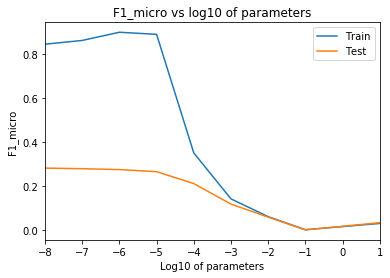

In [194]:
plot(pd.DataFrame(model.cv_results_))

In [176]:
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Hamming loss  0.04553958952636927


In [195]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.5013, Recall: 0.1931, F1-measure: 0.2788


### SVM

The best cross-validation score: 0.27361979657552343
The best parameters: {'estimator__alpha': 1e-05}


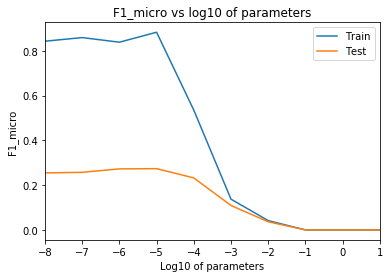

Hamming loss  0.046232892974841636


In [191]:
params = {
    "estimator__alpha": [10**-8, 10**-7,10**-6, 10**-5,10**-4,10**-3,10**-2, 10**-1, 10**1]
}

clf = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1',n_jobs=-1),n_jobs=-1)

model=GridSearchCV(clf, param_grid=params, scoring='f1_micro',n_jobs=-1,return_train_score=True,cv=3)

model.fit(x_train, y_train)
predictions=model.predict(x_test)
print ("The best cross-validation score:",model.best_score_)
print ("The best parameters:",model.best_params_)
plot(pd.DataFrame(model.cv_results_))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

In [192]:
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.4066, Recall: 0.2466, F1-measure: 0.3070


In [198]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("Scores on Diffrent Models and Featurizations")
x.field_names = ["Vectorizer","Model","f1_score", "featurizations used"]
x.add_row(["TFIDF" ,"Logistic Regression", 0.1987, "-"])
x.add_row(["TFIDF",  "SVM",  0.1983, "-"])
x.add_row(["TFIDF-Bi Grams",  "Logistic Regression",  0.2941,  "-"])
x.add_row(["TFIDF-Bi Grams" ,"SVM", 0.3028, "-"])
x.add_row(["TFIDF",  "Logistic Regression",  0.2372, "Topic Modelling(n_components=15)"])
x.add_row(["TFIDF",  "SVM",  0.2149, "Topic Modelling(n_components=20)"])
x.add_row(["TFIDF",  "Logistic Regression",  0.196, "Topic Modelling(n_components=20)"])
# x.add_row(["TFIDF",  "SVM",  0.2149, "Topic Modelling(n_components=20)"])
x.add_row(["TFIDF",  "Logistic Regression",  0.3051, "Topic Modelling + Topic Scores"])
x.add_row(["TFIDF",  "SVM",  0.3070, "Topic Modelling + Topic Scores"])
print(x)

Scores on Diffrent Models and Featurizations
+----------------+---------------------+----------+----------------------------------+
|   Vectorizer   |        Model        | f1_score |       featurizations used        |
+----------------+---------------------+----------+----------------------------------+
|     TFIDF      | Logistic Regression |  0.1987  |                -                 |
|     TFIDF      |         SVM         |  0.1983  |                -                 |
| TFIDF-Bi Grams | Logistic Regression |  0.2941  |                -                 |
| TFIDF-Bi Grams |         SVM         |  0.3028  |                -                 |
|     TFIDF      | Logistic Regression |  0.2372  | Topic Modelling(n_components=15) |
|     TFIDF      |         SVM         |  0.2149  | Topic Modelling(n_components=20) |
|     TFIDF      | Logistic Regression |  0.196   | Topic Modelling(n_components=20) |
|     TFIDF      | Logistic Regression |  0.3051  |  Topic Modelling + Topic Scores  